In [84]:
import math
import textwrap
import warnings
import deprecation

import matplotlib.pyplot as plt
import numpy as np


# Importing modules for plotting and hypothesis testing
import pandas as pd
import seaborn as sns
from scipy import stats
import pingouin as pg
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings("ignore")


In [85]:
# Rename all the unnamed columns for consistency and easy data handling
first_columns = ["Participant_ID", "RSVP", "TTS", "Trial_No"]

with open('Data/LanePositionDifference.csv') as f:
    lpd_num_cols = max(len(line.split(',')) for line in f)
with open('Data/BrakingInput.csv') as f:
    bi_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelAngles.csv') as f:
    swa_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelVelocity.csv') as f:
    swv_num_cols = max(len(line.split(',')) for line in f)

# Extracting the driving performance metric data
rt_df = pd.read_csv("Data/ReactionTimes.csv")
lpd_df = pd.read_csv("Data/LanePositionDifference.csv",
                     names=(first_columns + ["DP" + str(i) for i in range(0, lpd_num_cols - 4)]), skiprows=1)
bi_df = pd.read_csv("Data/BrakingInput.csv", names=(first_columns + ["DP" + str(i) for i in range(0, bi_num_cols - 4)]),
                    skiprows=1)
swa_df = pd.read_csv("Data/SteeringWheelAngles.csv",
                     names=(first_columns + ["DP" + str(i) for i in range(0, swa_num_cols - 4)]), skiprows=1)
swv_df = pd.read_csv("Data/SteeringWheelVelocity.csv",
                     names=(first_columns + ["DP" + str(i) for i in range(0, swv_num_cols - 4)]), skiprows=1)
scenario_df = pd.read_csv("Data/Scenario.csv")
collisions_df = pd.read_csv("Data/CollisionData.csv")

# Extracting reading comprehension data. NOTE: Extract numeric data from UBC Qualtrics
comp_test_df = pd.read_csv("Data/ComprehensionTest.csv")

# Extracting the survey data
nasa_tlx = pd.read_csv("Data/NASA-TLX.csv")
pre_study = pd.read_csv("Data/Pre-Study.csv")
post_study = pd.read_csv("Data/Post-Study.csv")

# Giving column names to all the tables that don't have a name.
rt_columns = first_columns + ["DP0"]
rt_df.columns = rt_columns
scenario_columns = first_columns + ["DP0"]
scenario_df.columns = scenario_columns
collisions_df.columns = first_columns + ["Event"]

In [86]:
# Utility Methods here
def is_outlier(data_point, q1, q3):
    IQR = q3 - q1
    return data_point < q1 - 1.5 * IQR or data_point > q3 + 1.5 * IQR


def get_stats(np_array):
    q1, q3 = np.percentile(np.sort(np_array), [25, 75])
    return q1, q3


def remove_outliers(df, column_name):
    q1_rsvp, q3_rsvp = get_stats(np.array(df[df["TPTAA"] == "RSVPNAA"][column_name].values))
    q1_rsvpa, q3_rsvpa = get_stats(np.array(df[df["TPTAA"] == "RSVPAA"][column_name].values))
    q1_stp, q3_stp = get_stats(np.array(df[df["TPTAA"] == "STPNAA"][column_name].values))
    q1_stpa, q3_stpa = get_stats(np.array(df[df["TPTAA"] == "STPAA"][column_name].values))
    index_list = []
    for i in range(0, df.shape[0]):
        if df.iloc[i]["TPTAA"] == "RSVPNAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvp, q3_rsvp):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "RSVPAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvpa, q3_rsvpa):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "STPNAA":
            if is_outlier(df.iloc[i][column_name], q1_stp, q3_stp):
                index_list.append(i)
        elif is_outlier(df.iloc[i][column_name], q1_stpa, q3_stpa):
            index_list.append(i)
    df.drop(index_list, axis=0, inplace=True)
    print("INFO: Total {} outliers removed.".format(len(index_list)))
    df.reset_index(inplace=True, drop=True)


def generate_refined(old_df, old_data_col, new_data_col):
    # The new data frame should have:
    # Text Presentation techniques and Audio assistance columns renamed and revalued
    # Should have the metric name as float
    refined_df = old_df.copy()
    # Drop the all unnecessary columns
    for col_name in old_df.columns:
        if col_name not in ["Participant_ID", "RSVP", "TTS", old_data_col]:
            refined_df.drop(col_name, axis=1, inplace=True)

    # Renaming the columns
    refined_df.rename(columns= {"RSVP" : "TPT", "TTS" : "Audio Assistance", old_data_col : new_data_col}, inplace=True)
    refined_df[new_data_col] = refined_df[new_data_col].astype(float)

    # Replace the o and 1 values to a meaningful one
    refined_df['TPT'] = refined_df['TPT'].replace({0: 'STP', 1: 'RSVP'})
    refined_df['Audio Assistance'] = refined_df['Audio Assistance'].replace({0: 'NAA', 1: 'AA'})
    refined_df[new_data_col].astype(float)
    return refined_df

def under_sampling(df, data_col):
    rus = RandomUnderSampler(random_state=50)
    df_leftover, df_c1 = rus.fit_resample(df[[data_col, "Participant_ID"]], df["TPTAA"].astype(str))
    new_df = pd.DataFrame()
    new_df["Participant_ID"] = df_leftover["Participant_ID"]
    new_df["TPTAA"] = df_c1
    new_df[data_col] = df_leftover[data_col].astype(float)
    return new_df

def create_seperate_arrays(coupled_df, data_col):
    rt_stp = coupled_df[coupled_df["TPTAA"] == "STPNAA"][data_col].values
    rt_stpa = coupled_df[coupled_df["TPTAA"] == "STPAA"][data_col].values
    rt_rsvp = coupled_df[coupled_df["TPTAA"] == "RSVPNAA"][data_col].values
    rt_rsvpa = coupled_df[coupled_df["TPTAA"] == "RSVPAA"][data_col].values
    return (rt_stp, rt_stpa, rt_rsvp, rt_rsvpa)


def plot_driving_metric(df, data_col, is_percentage):
    df_decoupled = decouple_df(df, data_col)
    plot = sns.barplot(data=df_decoupled, x="Text Presentation Technique", y=data_col, hue="Audio Assistance",
                       capsize=0.1)
    if is_percentage:
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f%%', label_type='center')
    else:
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f', label_type='center')


def plot_nasa_tlx(df, y_label, is_percentage=True):
    df_decoupled = decouple_df(df, y_label)
    plot = sns.barplot(data=df_decoupled, x="Text Presentation Technique", y=y_label, hue="Audio Assistance",
                       capsize=0.1)
    if is_percentage:
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f%%', label_type='center')
    else:
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f', label_type='center')
    plt.figure()


def analyze_nasa_tlx(df, data_col, plot_y_label, is_percentage=True):
    # Plotting the data points
    plot_nasa_tlx(df, y_label=plot_y_label, is_percentage=is_percentage)
    r_stp, r_stpa, r_rsvp, r_rsvpa = create_seperate_arrays(df, data_col=data_col)
    # Running Shapiro test
    if not (stats.shapiro(r_stp)[1] < 0.05 or stats.shapiro(r_stp)[1] < 0.05 or stats.shapiro(r_stp)[1] < 0.05 or
            stats.shapiro(r_stp)[1] < 0.05):
        # Run paired wilcoxon test
        stat1, p1 = stats.wilcoxon(r_rsvp, r_stp, alternative='less')
        print("Test: R_rsvp < R_stp [p value: {}]".format(p1))
        stat2, p2 = stats.wilcoxon(r_rsvpa, r_stpa, alternative='less')
        print("Test: R_rsvpa < R_stpa [p value: {}]".format(p2))
        stat3, p3 = stats.wilcoxon(r_rsvpa, r_rsvp, alternative='less')
        print("Test: R_rsvpa < R_rsvp [p value: {}]".format(p3))
        stat4, p4 = stats.wilcoxon(r_stpa, r_stp, alternative='less')
        print("Test: R_stpa < R_stp [p value: {}]".format(p4))
        stat5, p5 = stats.wilcoxon(r_rsvp, r_stp, alternative='greater')
        print("Test: R_rsvp > R_stp [p value: {}]".format(p5))
        stat6, p6 = stats.wilcoxon(r_rsvpa, r_stpa, alternative='greater')
        print("Test: R_rsvpa > R_stpa [p value: {}]".format(p6))
        stat7, p7 = stats.wilcoxon(r_rsvpa, r_rsvp, alternative='greater')
        print("Test: R_rsvpa > R_rsvp [p value: {}]".format(p7))
        stat8, p8 = stats.wilcoxon(r_stpa, r_stp, alternative='greater')
        print("Test: R_stpa > R_stp [p value: {}]".format(p8))
    else:
        # Run the p-test if the
        # Test if H_a: RT_rsvp  data set is normal< RT_stp
        print("H_0: R_rsvp = R_stp ; H_a: R_rsvp < R_stp")
        print(stats.ttest_rel(a=r_rsvp, b=r_stp, alternative="less"))
        print("H_0: R_rsvpa = R_stpa ; H_a: R_rsvpa < R_stpa")
        print(stats.ttest_rel(a=r_rsvpa, b=r_stpa, alternative="less"))
        # Test if H_a: R_aae < R_aad
        print("H_0: R_rsvpa = R_rsvp ; H_a: R_rsvpa < R_rsvp")
        print(stats.ttest_rel(a=r_rsvpa, b=r_rsvp, alternative="less"))
        print("H_0: R_stpa = R_stp ; H_a: R_stpa < R_stp")
        print(stats.ttest_rel(a=r_stpa, b=r_stp, alternative="less"))

        # Test if H_a: R_rsvp > R_stp
        print("H_0: R_rsvp = R_stp ; H_a: R_rsvp > R_stp")
        print(stats.ttest_rel(a=r_rsvp, b=r_stp, alternative="greater"))
        print("H_0: R_rsvpa = R_stpa ; H_a: R_rsvpa > R_stpa")
        print(stats.ttest_rel(a=r_rsvpa, b=r_stpa, alternative="greater"))
        # Test if H_a: R_aae > R_aad
        print("H_0: R_rsvpa = R_rsvp ; H_a: R_rsvpa > R_rsvp")
        print(stats.ttest_rel(a=r_rsvpa, b=r_rsvp, alternative="greater"))
        print("H_0: R_stpa = R_stp ; H_a: R_stpa > R_stp")
        print(stats.ttest_rel(a=r_stpa, b=r_stp, alternative="greater"))


def decouple_df(df, data_col):
    # This method also renames the values of "Audio Assistance" Column
    new_df = pd.DataFrame(columns=["Participant_ID", "Text Presentation Technique", "Audio Assistance", data_col])
    for index, row in df.iterrows():
        new_row = [row["Participant_ID"]]
        if "RSVP" in row["TPTAA"]:
            new_row.append("RSVP")
        else:
            new_row.append("STP")

        if "NAA" in row["TPTAA"]:
            new_row.append("Audio Assistance Disabled")
        else:
            new_row.append("Audio Assistance Enabled")
        new_row.append(row[data_col])
        new_df = new_df.append(
            {'Participant_ID': new_row[0], 'Text Presentation Technique': new_row[1], 'Audio Assistance': new_row[2], data_col: new_row[3]},
            ignore_index=True)
    new_df[data_col] = new_df[data_col].astype(float)
    new_df.sort_values(['Participant_ID', 'Text Presentation Technique', 'Audio Assistance'], ascending=[True, False, True], inplace=True)
    return new_df

def stat_analysis(coupled_df, metric_name, test="A"):
    # Test = A if running two-way repeated measures ANOVA test (two within-subjects factor).
    # Test = F if running friedman's test

    # Decoupling the dataframe for analysis
    decoupled_df = decouple_df(coupled_df, metric_name)

    # Check repeated measures ANOVA assumptions
    # TODO: Ask Shariff
    # Assumption of sphericity
    has_sphericity = True
    # Assumption of normality
    has_normality = True

    if has_sphericity and has_normality:
        print("Running two-way repeated measures ANOVA test (two within-subjects factor).")
        res = pg.rm_anova(dv=metric_name, within=['Audio Assistance', 'Text Presentation Technique'], subject='Participant_ID', data=decoupled_df, detailed=False)
        display(res)
    else:
        print("Data is not Normal. Running Friedman's test")

def is_normal(arr_stp, arr_stpa, arr_rsvp, arr_rsvpa):
    # Running Shapiro test to check if the dataset is normal
    return not (stats.shapiro(arr_stp)[1] < 0.05 or stats.shapiro(arr_stpa)[1] < 0.05 or stats.shapiro(arr_rsvp)[1] < 0.05 or stats.shapiro(arr_rsvpa)[1] < 0.05)


def report_stats(arr_stp, arr_stpa, arr_rsvp, arr_rsvpa, metric_name = "UNKNOWN"):
    print("MEAN AND STANDARD DEVIATION FOR EACH CASE")
    print("{} for RSVP w/o AA [M(SD): {}({})]".format(metric_name, round(float(np.mean(arr_rsvp)), 2), round(float(np.std(arr_rsvp)), 2)))
    print("{} for RSVP w AA [M(SD): {}({})]".format(metric_name, round(float(np.mean(arr_rsvpa)), 2), round(float(np.std(arr_rsvpa)), 2)))
    print("{} for STP w/o AA [M(SD): {}({})]".format(metric_name, round(float(np.mean(arr_stp)), 2), round(float(np.std(arr_stp)), 2)))
    print("{} for STP w AA [M(SD): {}({})]".format(metric_name, round(float(np.mean(arr_stpa)), 2), round(float(np.std(arr_stpa)), 2)))

In [87]:
exclusion = ['P01', 'P02', 'P03', 'P04', 'P05', 'P09']

# Excluding certain participants' driving performance
# Excluding certain participants' reading comprehension performance
# Exclusing certain participants' subjective surveys
for participant in exclusion:
    rt_df = rt_df[rt_df["Participant_ID"] != participant]
    lpd_df = lpd_df[lpd_df["Participant_ID"] != participant]
    bi_df = bi_df[bi_df["Participant_ID"] != participant]
    swa_df = swa_df[swa_df["Participant_ID"] != participant]
    swv_df = swv_df[swv_df["Participant_ID"] != participant]
    comp_test_df = comp_test_df[comp_test_df["Q1"] != participant]
    nasa_tlx = nasa_tlx[nasa_tlx["Q1"] != participant]
    pre_study = pre_study[pre_study["ID"] != participant]
    post_study = post_study[post_study["Q1"] != participant]

# TODO: Write code to remove the data point of Major collisions.
# WARNING: Take note of the leading white space in the data types of Event Column
exclusion_df = collisions_df[collisions_df["Event"] == " Major Collision"]
for index, row in exclusion_df.iterrows():
    rt_df = rt_df[(rt_df["Participant_ID"] != row["Participant_ID"]) | (rt_df["RSVP"] != row["RSVP"]) | (
            rt_df["TTS"] != row["TTS"]) | (rt_df["Trial_No"] != row["Trial_No"])]
    lpd_df = lpd_df[(lpd_df["Participant_ID"] != row["Participant_ID"]) | (lpd_df["RSVP"] != row["RSVP"]) | (
            lpd_df["TTS"] != row["TTS"]) | (lpd_df["Trial_No"] != row["Trial_No"])]
    bi_df = bi_df[(bi_df["Participant_ID"] != row["Participant_ID"]) | (bi_df["RSVP"] != row["RSVP"]) | (
            bi_df["TTS"] != row["TTS"]) | (bi_df["Trial_No"] != row["Trial_No"])]
    swa_df = swa_df[(swa_df["Participant_ID"] != row["Participant_ID"]) | (swa_df["RSVP"] != row["RSVP"]) | (
            swa_df["TTS"] != row["TTS"]) | (swa_df["Trial_No"] != row["Trial_No"])]
    swv_df = swv_df[(swv_df["Participant_ID"] != row["Participant_ID"]) | (swv_df["RSVP"] != row["RSVP"]) | (
            swv_df["TTS"] != row["TTS"]) | (swv_df["Trial_No"] != row["Trial_No"])]

# Resetting indexes since rows may have been dropped.
rt_df.reset_index(inplace=True, drop=True)
lpd_df.reset_index(inplace=True, drop=True)
bi_df.reset_index(inplace=True, drop=True)
swa_df.reset_index(inplace=True, drop=True)
swv_df.reset_index(inplace=True, drop=True)

In [88]:
# Analyze how many collisions occurred for each case.
c_stp = len(collisions_df[
                ((collisions_df["Event"] == " Minor Collision") | (collisions_df["Event"] == " Major Collision")) & (
                            (collisions_df["RSVP"] == 0) & (collisions_df["TTS"] == 0))].values)
c_stpa = len(collisions_df[
                 ((collisions_df["Event"] == " Minor Collision") | (collisions_df["Event"] == " Major Collision")) & (
                             (collisions_df["RSVP"] == 0) & (collisions_df["TTS"] == 1))].values)
c_rsvp = len(collisions_df[
                 ((collisions_df["Event"] == " Minor Collision") | (collisions_df["Event"] == " Major Collision")) & (
                             (collisions_df["RSVP"] == 1) & (collisions_df["TTS"] == 0))].values)
c_rsvpa = len(collisions_df[
                  ((collisions_df["Event"] == " Minor Collision") | (collisions_df["Event"] == " Major Collision")) & (
                              (collisions_df["RSVP"] == 1) & (collisions_df["TTS"] == 1))].values)

# Printing the values
print("Number of Collisions in STP without audio assistance:", str(c_stp))
print("Number of Collisions in STP with audio assistance:", str(c_stpa))
print("Number of Collisions in RSVP without audio assistance:", str(c_rsvp))
print("Number of Collisions in RSVP with audio assistance:", str(c_rsvpa)) # One major collsision here.

Number of Collisions in STP without audio assistance: 4
Number of Collisions in STP with audio assistance: 2
Number of Collisions in RSVP without audio assistance: 1
Number of Collisions in RSVP with audio assistance: 3


INFO: Total 12 outliers removed.
MEAN AND STANDARD DEVIATION FOR EACH CASE
RT for RSVP w/o AA [M(SD): 1.15(0.26)]
RT for RSVP w AA [M(SD): 1.09(0.23)]
RT for STP w/o AA [M(SD): 1.1(0.22)]
RT for STP w AA [M(SD): 1.19(0.31)]


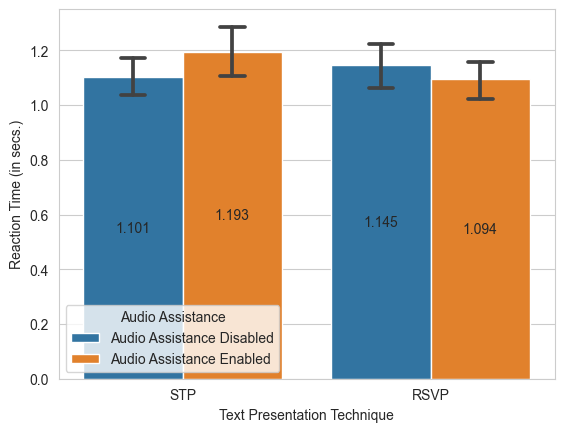

In [93]:
# Restructuring the data frame.
rt_refined = generate_refined(rt_df, "DP0", "RT")

# Combine columns TPT and Audio Assistance
rt_combined = pd.DataFrame()
rt_combined["Participant_ID"] = rt_refined["Participant_ID"].values
rt_combined["TPTAA"] = rt_refined["TPT"].values + rt_refined["Audio Assistance"].values
rt_combined["Reaction Time (in secs.)"] = rt_refined["RT"].values

# Removing the outliers from the data frame
remove_outliers(rt_combined, "Reaction Time (in secs.)")

# Under sampling the data set
rt_combined = under_sampling(rt_combined, "Reaction Time (in secs.)")

# Creating separate arrays for analysis
rt_stp, rt_stpa, rt_rsvp, rt_rsvpa = create_seperate_arrays(rt_combined, "Reaction Time (in secs.)")

# For doing the hypothesis,export the dataframe to CSV for the use in SPSS
decouple_df(rt_combined, "Reaction Time (in secs.)").to_csv('Refined/ReactionTimes.csv', index=False, encoding='utf-8')

# plot graph
plot_driving_metric(rt_combined, "Reaction Time (in secs.)", False)

# Report the mean and SD for each of the individual cases
report_stats(arr_stp=rt_stp, arr_stpa=rt_stpa, arr_rsvp=rt_rsvp, arr_rsvpa=rt_rsvpa, metric_name="RT")

INFO: Total 4 outliers removed.
MEAN AND STANDARD DEVIATION FOR EACH CASE
ALPO for RSVP w/o AA [M(SD): 0.62(0.23)]
ALPO for RSVP w AA [M(SD): 0.69(0.22)]
ALPO for STP w/o AA [M(SD): 0.6(0.2)]
ALPO for STP w AA [M(SD): 0.66(0.29)]


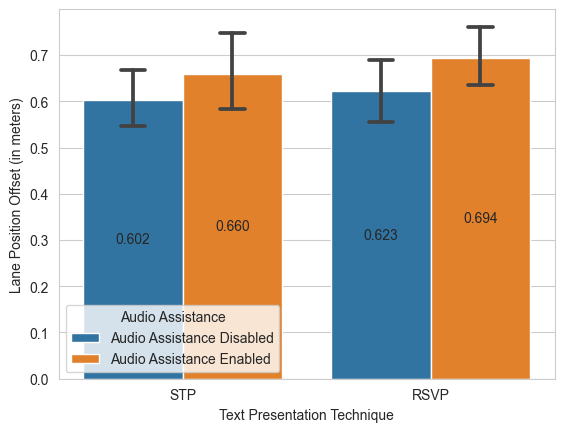

In [96]:
# Analyzing the Average Lane Position Offset.
sd_lane_pos = []
lpd_df_copy = lpd_df.copy()
for i in range(0, lpd_df_copy.shape[0]):
    dp_array = [dp for dp in lpd_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    sd_lane_pos.append(sum(dp_array) / len(dp_array))
lpd_df_copy["AVG"] = sd_lane_pos

# Restructuring the data frame.
lpd_refined = generate_refined(lpd_df_copy, "AVG", "LPO")

# Combine columns TPT and Audio Assistance
lpd_combined = pd.DataFrame()
lpd_combined["Participant_ID"] = lpd_refined["Participant_ID"].values
lpd_combined["TPTAA"] = lpd_refined["TPT"].values + lpd_refined["Audio Assistance"].values
lpd_combined["Lane Position Offset (in meters)"] = lpd_refined["LPO"].values

# Removing the outliers from the data frame
remove_outliers(lpd_combined, "Lane Position Offset (in meters)")

# Under sampling the data set
lpd_combined = under_sampling(lpd_combined, "Lane Position Offset (in meters)")

# Creating separate arrays for analysis
alpo_stp, alpo_stpa, alpo_rsvp, alpo_rsvpa = create_seperate_arrays(lpd_combined, "Lane Position Offset (in meters)")

# For doing the hypothesis, export the dataframe to CSV for the use in SPSS
decouple_df(lpd_combined, "Lane Position Offset (in meters)").to_csv('Refined/ALPO.csv', index=False, encoding='utf-8')

# Getting decoupled dataframe for the graph
plot_driving_metric(lpd_combined, "Lane Position Offset (in meters)", False)

# Report the mean ans SD for each of the individual cases
report_stats(arr_stp=alpo_stp, arr_stpa=alpo_stpa, arr_rsvp=alpo_rsvp, arr_rsvpa=alpo_rsvpa, metric_name="ALPO")

INFO: Total 2 outliers removed.
MEAN AND STANDARD DEVIATION FOR EACH CASE
SDLP for RSVP w/o AA [M(SD): 0.3(0.13)]
SDLP for RSVP w AA [M(SD): 0.36(0.13)]
SDLP for STP w/o AA [M(SD): 0.29(0.14)]
SDLP for STP w AA [M(SD): 0.31(0.13)]


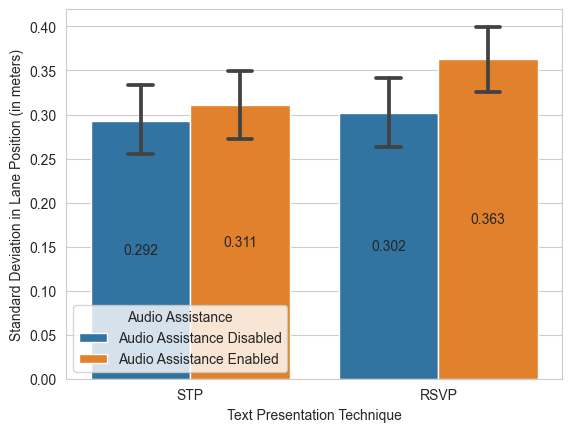

In [97]:
# Analyzing the Standard Deviation in Lane Position.
sd_lane_pos = []
lpd_df_copy = lpd_df.copy()
for i in range(0, lpd_df_copy.shape[0]):
    dp_array = [dp for dp in lpd_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    sd_lane_pos.append(np.std(dp_array))
lpd_df_copy["SD"] = sd_lane_pos

# Restructuring the data frame.
lpd_refined = generate_refined(lpd_df_copy, "SD", "SDLP")

# Combine columns TPT and Audio Assistance
lpd_combined = pd.DataFrame()
lpd_combined["Participant_ID"] = lpd_refined["Participant_ID"].values
lpd_combined["TPTAA"] = lpd_refined["TPT"].values + lpd_refined["Audio Assistance"].values
lpd_combined["Standard Deviation in Lane Position (in meters)"] = lpd_refined["SDLP"].values

# Removing the outliers from the data frame
remove_outliers(lpd_combined, "Standard Deviation in Lane Position (in meters)")

# Under sampling the data set
lpd_combined = under_sampling(lpd_combined, "Standard Deviation in Lane Position (in meters)")

# Creating separate arrays for analysis
sdlp_stp, sdlp_stpa, sdlp_rsvp, sdlp_rsvpa = create_seperate_arrays(lpd_combined, "Standard Deviation in Lane Position (in meters)")

# For doing the hypothesis, export the dataframe to CSV for the use in SPSS
decouple_df(lpd_combined, "Standard Deviation in Lane Position (in meters)").to_csv('Refined/SDLP.csv', index=False, encoding='utf-8')

# Getting decoupled dataframe for the graph
plot_driving_metric(lpd_combined, "Standard Deviation in Lane Position (in meters)", False)

# Report the mean ans SD for each of the individual cases
report_stats(arr_stp=sdlp_stp, arr_stpa=sdlp_stpa, arr_rsvp=sdlp_rsvp, arr_rsvpa=sdlp_rsvpa, metric_name="SDLP")

INFO: Total 9 outliers removed.
MEAN AND STANDARD DEVIATION FOR EACH CASE
SDSWA for RSVP w/o AA [M(SD): 19.62(11.42)]
SDSWA for RSVP w AA [M(SD): 23.39(13.79)]
SDSWA for STP w/o AA [M(SD): 15.7(6.9)]
SDSWA for STP w AA [M(SD): 15.6(7.62)]


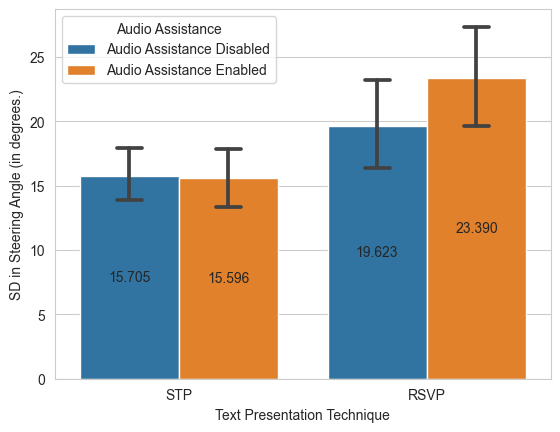

In [98]:
# Analyzing the Standard Deviation of Steering Wheel Angle
SWRRs = []
swa_df_copy = swa_df.copy()
for i in range(0, swa_df_copy.shape[0]):
    dp_array = [dp for dp in swa_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    SWRRs.append(np.std(dp_array))
swa_df_copy["SD"] = SWRRs

# Restructuring the data frame.
sdswa_refined = generate_refined(swa_df_copy, "SD", "SDSWA")

# Combine columns TPT and Audio Assistance
sdswa_combined = pd.DataFrame()
sdswa_combined["Participant_ID"] = sdswa_refined["Participant_ID"].values
sdswa_combined["TPTAA"] = sdswa_refined["TPT"].values + sdswa_refined["Audio Assistance"].values
sdswa_combined["SD in Steering Angle (in degrees.)"] = sdswa_refined["SDSWA"].values

# Removing the outliers from the data frame
remove_outliers(sdswa_combined, "SD in Steering Angle (in degrees.)")

# Under sampling the data set
sdswa_combined = under_sampling(sdswa_combined, "SD in Steering Angle (in degrees.)")

# Create separate arrays for 2 x 2 cases
sdswa_stp, sdswa_stpa, sdswa_rsvp, sdswa_rsvpa = create_seperate_arrays(sdswa_combined,
                                                                        "SD in Steering Angle (in degrees.)")

# For doing the hypothesis, export the dataframe to CSV for the use in SPSS
decouple_df(sdswa_combined, "SD in Steering Angle (in degrees.)").to_csv('Refined/SDSWA.csv', index=False, encoding='utf-8')

# plot graph
plot_driving_metric(sdswa_combined, "SD in Steering Angle (in degrees.)", False)

# Report the mean ans SD for each of the individual cases
report_stats(arr_stp=sdswa_stp, arr_stpa=sdswa_stpa, arr_rsvp=sdswa_rsvp, arr_rsvpa=sdswa_rsvpa, metric_name="SDSWA")

INFO: Total 17 outliers removed.
MEAN AND STANDARD DEVIATION FOR EACH CASE
MSWR for RSVP w/o AA [M(SD): 10.3(12.82)]
MSWR for RSVP w AA [M(SD): 9.42(11.01)]
MSWR for STP w/o AA [M(SD): 8.42(9.77)]
MSWR for STP w AA [M(SD): 5.98(7.05)]


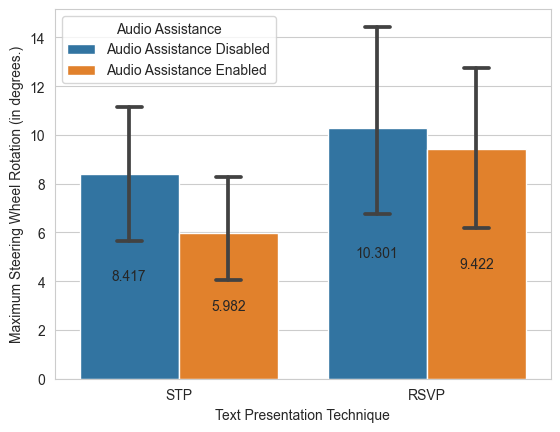

In [99]:
# Analyzing Maximum Steering Wheel Rotation
SWRRs = []
swa_df_copy = swa_df.copy()
for i in range(0, swa_df_copy.shape[0]):
    dp_array = [dp for dp in swa_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    SWRRs.append(max(dp_array))
swa_df_copy["MAX"] = SWRRs

# Restructuring the data frame.
mswr_refined = generate_refined(swa_df_copy, "MAX", "MAX")

# Combine columns TPT and Audio Assistance
mswr_combined = pd.DataFrame()
mswr_combined["Participant_ID"] = mswr_refined["Participant_ID"].values
mswr_combined["TPTAA"] = mswr_refined["TPT"].values + mswr_refined["Audio Assistance"].values
mswr_combined["Maximum Steering Wheel Rotation (in degrees.)"] = mswr_refined["MAX"].values

# Removing the outliers from the data frame
remove_outliers(mswr_combined, "Maximum Steering Wheel Rotation (in degrees.)")

# Under sampling the data set
mswr_combined = under_sampling(mswr_combined, "Maximum Steering Wheel Rotation (in degrees.)")

# Create separate arrays for 2 x 2 cases
mswr_stp, mswr_stpa, mswr_rsvp, mswr_rsvpa = create_seperate_arrays(mswr_combined,
                                                                            "Maximum Steering Wheel Rotation (in degrees.)")

# For doing the hypothesis, export the dataframe to CSV for the use in SPSS
decouple_df(mswr_combined, "Maximum Steering Wheel Rotation (in degrees.)").to_csv('Refined/MSWR.csv', index=False, encoding='utf-8')

# plot graph
plot_driving_metric(mswr_combined, "Maximum Steering Wheel Rotation (in degrees.)", False)

# Report the mean ans SD for each of the individual cases
report_stats(arr_stp=mswr_stp, arr_stpa=mswr_stpa, arr_rsvp=mswr_rsvp, arr_rsvpa=mswr_rsvpa, metric_name="MSWR")

In [ ]:
# # Analysing the Breaking Input Rate
# # Creating a duplicate df to retain original data, and calculating rate
# bi_df_copy = bi_df.copy()
# BIRs = []
# for i in range(0, bi_df_copy.shape[0]):
#     dp_array = [dp for dp in bi_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
#     count = 0
#     for value in dp_array:
#         if value != 0:
#             count += 1
#     rate = float(count) / len(dp_array)
#     BIRs.append(rate)
# bi_df_copy["RATE"] = BIRs
#
# # Restructuring the data frame.
# bir_refined = generate_refined(bi_df_copy, "RATE", "RATE")
#
# # Combine columns TPT and Audio Assistance
# bir_combined = pd.DataFrame()
# bir_combined["TPTAA"] = bir_refined["TPT"].values + bir_refined["Audio Assistance"].values
# bir_combined["Braking input rate (inputs/second)"] = bir_refined["RATE"].values
#
# # Removing the outliers from the data frame
# remove_outliers(bir_combined, "Braking input rate (inputs/second)")
#
# # Under sampling the data set
# bir_combined = under_sampling(bir_combined, "Braking input rate (inputs/second)")
#
# # Create separate arrays for 2 x 2 cases
# bir_stp, bir_stpa, bir_rsvp, bir_rsvpa = create_seperate_arrays(bir_combined, "Braking input rate (inputs/second)")
#
# # Test if the distribution is normal.
# print("Shapiro Test for BIR_stp; p-value: ", stats.shapiro(bir_stp)[1])
# print("Shapiro Test for BIR_rsvp; p-value: ", stats.shapiro(bir_rsvp)[1])
# print("Shapiro Test for BIR_stpa; p-value: ", stats.shapiro(bir_stpa)[1])
# print("Shapiro Test for BIR_rsvpa; p-value: ", stats.shapiro(bir_rsvpa)[1])
#
# # Do hypothesis Testing.
# test_hypothesis(arr_stp=bir_stp, arr_stpa=bir_stpa, arr_rsvp=bir_rsvp, arr_rsvpa=bir_rsvpa, metric_name="BIR")
#
# # plot graph
# plot_driving_metric(bir_combined, "Braking input rate (inputs/second)", False)
#
# # Report the mean ans SD for each of the individual cases
# report_stats(arr_stp=bir_stp, arr_stpa=bir_stpa, arr_rsvp=bir_rsvp, arr_rsvpa=bir_rsvpa, metric_name="BIR")

INFO: Total 1 outliers removed.
MEAN AND STANDARD DEVIATION FOR EACH CASE
MBI for RSVP w/o AA [M(SD): 30.45(22.8)]
MBI for RSVP w AA [M(SD): 31.62(25.09)]
MBI for STP w/o AA [M(SD): 37.99(28.52)]
MBI for STP w AA [M(SD): 31.4(21.63)]


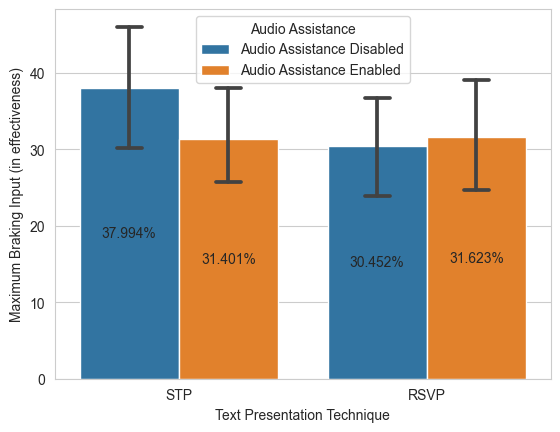

In [100]:
# Analysing the Maximum breaking input
# Creating a duplicate df to retain original data, and calculating rate
bi_df_copy = bi_df.copy()
MBSs = []
for i in range(0, bi_df_copy.shape[0]):
    dp_array = [dp for dp in bi_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MBSs.append(max(dp_array) * 100)
bi_df_copy["MAX"] = MBSs

# Restructuring the data frame.
mbi_refined = generate_refined(bi_df_copy, "MAX", "MAX")

# Combine columns TPT and Audio Assistance
mbi_combined = pd.DataFrame()
mbi_combined["Participant_ID"] = mbi_refined["Participant_ID"].values
mbi_combined["TPTAA"] = mbi_refined["TPT"].values + mbi_refined["Audio Assistance"].values
mbi_combined["Maximum Braking Input (in effectiveness)"] = mbi_refined["MAX"].values

# Removing the outliers from the data frame
remove_outliers(mbi_combined, "Maximum Braking Input (in effectiveness)")

# Under sampling the data set
mbi_combined = under_sampling(mbi_combined, "Maximum Braking Input (in effectiveness)")

# Create separate arrays for 2 x 2 cases
mbi_stp, mbi_stpa, mbi_rsvp, mbi_rsvpa = create_seperate_arrays(mbi_combined,
                                                                "Maximum Braking Input (in effectiveness)")

# For doing the hypothesis, export the dataframe to CSV for the use in SPSS
decouple_df(mbi_combined, "Maximum Braking Input (in effectiveness)").to_csv('Refined/MBI.csv', index=False, encoding='utf-8')

# plot graph
plot_driving_metric(mbi_combined, "Maximum Braking Input (in effectiveness)", True)

# Report the mean ans SD for each of the individual cases
report_stats(arr_stp=mbi_stp, arr_stpa=mbi_stpa, arr_rsvp=mbi_rsvp, arr_rsvpa=mbi_rsvpa, metric_name="MBI")

INFO: Total 8 outliers removed.
MEAN AND STANDARD DEVIATION FOR EACH CASE
AVA for RSVP w/o AA [M(SD): 17.97(12.16)]
AVA for RSVP w AA [M(SD): 17.08(12.12)]
AVA for STP w/o AA [M(SD): 21.46(15.49)]
AVA for STP w AA [M(SD): 16.71(8.99)]


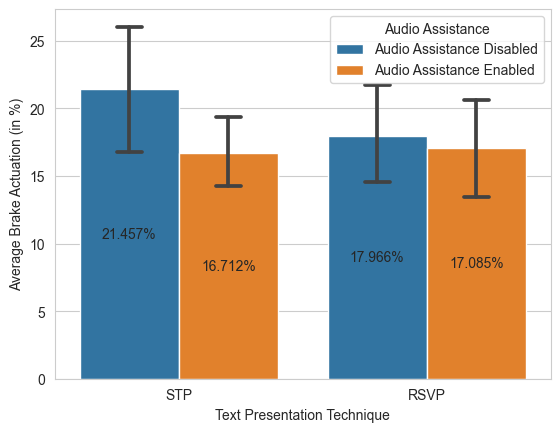

In [102]:
# Analysing the Average Brake Actuation
# Creating a duplicate df to retain original data, and calculating rate
bi_df_copy = bi_df.copy()
ABAs = []
for i in range(0, bi_df_copy.shape[0]):
    dp_array = [dp for dp in bi_df_copy.iloc[i].values.tolist()[4:] if not (pd.isna(dp) or math.isclose(0, dp, rel_tol=1e-5))]
    ABAs.append(0 if pd.isna(np.mean(dp_array)) else np.mean(dp_array)*100)
bi_df_copy["AVA"] = ABAs

# Restructuring the data frame.
ava_refined = generate_refined(bi_df_copy, "AVA", "ABA")

# Combine columns TPT and Audio Assistance
ava_combined = pd.DataFrame()
ava_combined["Participant_ID"] = ava_refined["Participant_ID"].values
ava_combined["TPTAA"] = ava_refined["TPT"].values + ava_refined["Audio Assistance"].values
ava_combined["Average Brake Actuation (in %)"] = ava_refined["ABA"].values

# Removing the outliers from the data frame
remove_outliers(ava_combined, "Average Brake Actuation (in %)")

# Under sampling the data set
ava_combined = under_sampling(ava_combined, "Average Brake Actuation (in %)")

# Create separate arrays for 2 x 2 cases
ava_stp, ava_stpa, ava_rsvp, ava_rsvpa = create_seperate_arrays(ava_combined, "Average Brake Actuation (in %)")

# For doing the hypothesis, export the dataframe to CSV for the use in SPSS
decouple_df(ava_combined, "Average Brake Actuation (in %)").to_csv('Refined/ABA.csv', index=False, encoding='utf-8')

# plot graph
plot_driving_metric(ava_combined, "Average Brake Actuation (in %)", True)

# Report the mean ans SD for each of the individual cases
report_stats(arr_stp=ava_stp, arr_stpa=ava_stpa, arr_rsvp=ava_rsvp, arr_rsvpa=ava_rsvpa, metric_name="AVA")

INFO: Total 12 outliers removed.
MEAN AND STANDARD DEVIATION FOR EACH CASE
SWRR for RSVP w/o AA [M(SD): 3.4(3.95)]
SWRR for RSVP w AA [M(SD): 3.17(4.42)]
SWRR for STP w/o AA [M(SD): 5.88(6.47)]
SWRR for STP w AA [M(SD): 4.64(4.65)]


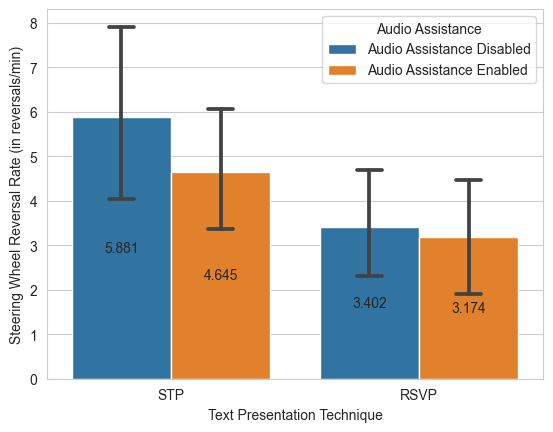

In [103]:
# Analyzing the Steering Wheel Reversal Rate
SWRRs = []
swa_df_copy = swa_df.copy()
GapSize = 5.0
for i in range(0, swa_df_copy.shape[0]):
    dp_array = [dp for dp in swa_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    count = 0
    total_time = 0
    for j in range(0, len(dp_array) - 1):
        if abs(dp_array[j] - dp_array[j + 1]) > GapSize:
            count += 1
        total_time += 0.2

    SWRRs.append((count / total_time)*60)
swa_df_copy["RATE"] = SWRRs

# Restructuring the data frame.
swrr_refined = generate_refined(swa_df_copy, "RATE", "RATE")

# Combine columns TPT and Audio Assistance
swrr_combined = pd.DataFrame()
swrr_combined["Participant_ID"] = swrr_refined["Participant_ID"].values
swrr_combined["TPTAA"] = swrr_refined["TPT"].values + swrr_refined["Audio Assistance"].values
swrr_combined["Steering Wheel Reversal Rate (in reversals/min)"] = swrr_refined["RATE"].values

# Removing the outliers from the data frame
remove_outliers(swrr_combined, "Steering Wheel Reversal Rate (in reversals/min)")

# Under sampling the data set
swrr_combined = under_sampling(swrr_combined, "Steering Wheel Reversal Rate (in reversals/min)")

# Create separate arrays for 2 x 2 cases
swrr_stp, swrr_stpa, swrr_rsvp, swrr_rsvpa = create_seperate_arrays(swrr_combined,
                                                                    "Steering Wheel Reversal Rate (in reversals/min)")

# For doing the hypothesis, export the dataframe to CSV for the use in SPSS
decouple_df(swrr_combined, "Steering Wheel Reversal Rate (in reversals/min)").to_csv('Refined/SWRR.csv', index=False, encoding='utf-8')

# plot graph
plot_driving_metric(swrr_combined, "Steering Wheel Reversal Rate (in reversals/min)", False)

# Report the mean ans SD for each of the individual cases
report_stats(arr_stp=swrr_stp, arr_stpa=swrr_stpa, arr_rsvp=swrr_rsvp, arr_rsvpa=swrr_rsvpa, metric_name="SWRR")

In [ ]:
    # Analyzing NASA-TLX form.
# Q1: Enter Participant ID
# Q2: Type of Display
# Q3: Text Presentation Technique
# Q4_1 How mentally demanding was the task?
# Q4_2: How physically demanding was the task?
# Q4_3: How hurried or rushed was the pace of the task?
# Q4_4: How successful were you in accomplishing the task?
# Q4_5: How hard did you have to work to accomplish your performance in the task?
# Q4_6: How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?
axis_labels = [
    "How mentally demanding was the task?",
    "How physically demanding was the task?",
    "How hurried or rushed was the pace of the task?",
    "How successful were you in accomplishing the task?",
    "How hard did you have to work to accomplish your performance in the task?",
    "How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?"
]
labels = []
for label in axis_labels:
    labels.append(textwrap.fill(label, width=22,
                                break_long_words=False))

nasa_tlx_stp = nasa_tlx[nasa_tlx["Q3"] == "Scrolling Text Presentation (STP)"]
nasa_tlx_rsvp = nasa_tlx[nasa_tlx["Q3"] == "Rapid Serial Visual Presentation (RSVP)"]
nasa_tlx_aae = nasa_tlx[nasa_tlx["Q2"] == "Yes (HUDAA)"]
nasa_tlx_aad = nasa_tlx[nasa_tlx["Q2"] == "No (HUD)"]

TPT_diff = np.array([
    ["Q1", np.mean(nasa_tlx_stp["Q4_1"]), np.mean(nasa_tlx_rsvp["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_stp["Q5_1"]), np.mean(nasa_tlx_rsvp["Q5_1"])],
    ["Q3", np.mean(nasa_tlx_stp["Q6_1"]), np.mean(nasa_tlx_rsvp["Q6_1"])],
    ["Q4", np.mean(nasa_tlx_stp["Q7_1"]), np.mean(nasa_tlx_rsvp["Q7_1"])],
    ["Q5", np.mean(nasa_tlx_stp["Q8_1"]), np.mean(nasa_tlx_rsvp["Q8_1"])],
    ["Q6", np.mean(nasa_tlx_stp["Q9_1"]), np.mean(nasa_tlx_rsvp["Q9_1"])],

])

AA_diff = np.array([
    ["Q1", np.mean(nasa_tlx_aad["Q4_1"]), np.mean(nasa_tlx_aae["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_aad["Q5_1"]), np.mean(nasa_tlx_aae["Q5_1"])],
    ["Q3", np.mean(nasa_tlx_aad["Q6_1"]), np.mean(nasa_tlx_aae["Q6_1"])],
    ["Q4", np.mean(nasa_tlx_aad["Q7_1"]), np.mean(nasa_tlx_aae["Q7_1"])],
    ["Q5", np.mean(nasa_tlx_aad["Q8_1"]), np.mean(nasa_tlx_aae["Q8_1"])],
    ["Q6", np.mean(nasa_tlx_aad["Q9_1"]), np.mean(nasa_tlx_aae["Q9_1"])],
])

nasa_tlx_tpt_df = pd.DataFrame(TPT_diff, columns=["Question", "STP", "RSVP"])
nasa_tlx_aa_df = pd.DataFrame(AA_diff, columns=["Question", "AAD", "AAE"])

display(nasa_tlx_tpt_df)

# Converting the column types
nasa_tlx_tpt_df["Question"] = nasa_tlx_tpt_df["Question"].astype(str)
nasa_tlx_tpt_df["STP"] = nasa_tlx_tpt_df["STP"].astype(float)
nasa_tlx_tpt_df["RSVP"] = nasa_tlx_tpt_df["RSVP"].astype(float)

nasa_tlx_aa_df["Question"] = nasa_tlx_aa_df["Question"].astype(str)
nasa_tlx_aa_df["AAD"] = nasa_tlx_aa_df["AAD"].astype(float)
nasa_tlx_aa_df["AAE"] = nasa_tlx_aa_df["AAE"].astype(float)

# RSVP vs STP
bplot = nasa_tlx_tpt_df.plot(x="Question", kind="bar", width=0.8, rot=0, figsize=(15, 5))

bplot.set_xticklabels(labels, rotation=0)

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

# Audio assistance disabled vs audio assistance enabled
bplot2 = nasa_tlx_aa_df.plot(x="Question", kind="bar", width=0.8, rot=0, figsize=(15, 5))
bplot2.set_xticklabels(labels, rotation=0)
bplot2.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"])

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot2.containers:
    bplot2.bar_label(p, fmt='%.3f', label_type='edge')

In [ ]:
# Analyzing NASA-TLX form.
# Q1: Enter Participant ID
# Q2: Type of Display
# Q3: Text Presentation Technique
# Q4_1: How mentally demanding was the task?
# Q5_1: How physically demanding was the task?
# Q6_1: How hurried or rushed was the pace of the task?
# Q7_1: How successful were you in accomplishing the task?
# Q8_1: How hard did you have to work to accomplish your performance in the task?
# Q9_1: How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?

axis_labels = [
    "How mentally demanding was the task?",
    "How physically demanding was the task?",
    "How hurried or rushed was the pace of the task?",
    "How successful were you in accomplishing the task?",
    "How hard did you have to work to accomplish your performance in the task?",
    "How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?"
]
# Rename the dataframe to make it standardized
nasa_tlx_refined = nasa_tlx.rename(
    columns={'Q1': 'Participant_ID', 'Q3': 'TPT', 'Q2': 'AA', 'Q4_1': 'Q1', 'Q5_1': 'Q2', 'Q6_1': 'Q3', 'Q7_1': 'Q4',
             'Q8_1': 'Q5', 'Q9_1': 'Q6'}, inplace=False)

# Combining TPT and AA columns
nasa_tlx_combined = pd.DataFrame()
tpt_list = [("STP" if "STP" in value else "RSVP") for value in nasa_tlx_refined["TPT"].values.tolist()]
aa_list = [("NAA" if "No" in value else "AA") for value in nasa_tlx_refined["AA"].values.tolist()]
nasa_tlx_combined["TPTAA"] = [tpt_list[i] + aa_list[i] for i in range(0, len(aa_list))]
for i in range(1, 7):
    nasa_tlx_combined["Q" + str(i)] = nasa_tlx_refined["Q" + str(i)].values

# Removing the outliers
for i in range(1, 7):
    remove_outliers(nasa_tlx_combined, "Q" + str(i))

# Under sampling the data set and creating separate data frames
Ratings = []
for i in range(1, 7):
    df = under_sampling(nasa_tlx_combined, "Q" + str(i))
    Ratings.append(df)
# Rating[0] = "Q1", Rating[1] = "Q2", Rating[2] = "Q3", Rating[3] = "Q4", Rating[4] = "Q5", Rating[5] = "Q6"

# Analyze the questions individually
print("Testing and plotting for Q:", axis_labels[0])
analyze_nasa_tlx(df=Ratings[0], data_col="Q1", plot_y_label=axis_labels[0])

print("\nTesting and plotting for Q:", axis_labels[1])
analyze_nasa_tlx(df=Ratings[1], data_col="Q2", plot_y_label=axis_labels[1])

print("\nTesting and plotting for Q:", axis_labels[2])
analyze_nasa_tlx(df=Ratings[2], data_col="Q3", plot_y_label=axis_labels[2])

print("\nTesting and plotting for Q:", axis_labels[3])
analyze_nasa_tlx(df=Ratings[3], data_col="Q4", plot_y_label=axis_labels[3])

print("\nTesting and plotting for Q:", axis_labels[4])
analyze_nasa_tlx(df=Ratings[4], data_col="Q5", plot_y_label=axis_labels[4])

print("\nTesting and plotting for Q:", axis_labels[5])
analyze_nasa_tlx(df=Ratings[5], data_col="Q6", plot_y_label=axis_labels[5])

In [ ]:
correct_answers = [1, 2, 3, 4, 2, 1, 3, 2, 4, 2, 4, 2, 3, 3, 4, 1, 2, 1, 3, 2, 1, 3, 4, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 2,
                   1, 4, 4, 4, 2]
acc_col = []
for i in range(0, comp_test_df.shape[0]):
    try:
        row = [dp for dp in comp_test_df.iloc[i].values.tolist()[4:]]
        correct = 0
        incorrect = 0
        for j in range(0, len(correct_answers)):
            if not math.isnan(row[j]):
                if row[j] == correct_answers[j]:
                    correct += 1
                else:
                    incorrect += 1
        acc_col.append(float(correct) / (correct + incorrect))
    except Exception as e:
        print(i, e)

comp_test_acc_df = pd.DataFrame().assign(Participant_ID=comp_test_df['Q1'], AA=comp_test_df['Qa'],
                                         TPT=comp_test_df['Qb'], TF=comp_test_df['Qc'])
comp_test_acc_df['Accuracy'] = acc_col
# AA = 1 If Enabled, 2 If Disabled
# TPT = 1 If STP, 2 If RSVP
# TF ranges between 1-8

# Creating a dataframe to plot the data
comp_test_refined_df = pd.DataFrame(columns=['Participant_ID', 'TPT', 'Audio Assistance', 'Accuracy'])
comp_test_refined_df["Accuracy"] = comp_test_refined_df["Accuracy"].astype(float)

for participant in comp_test_acc_df["Participant_ID"].unique():
    # Get the dataframe for the participant
    participant_df = comp_test_acc_df[comp_test_acc_df["Participant_ID"] == participant]

    # Get the dataframe for each of the four cases
    df_row_stp = [participant, "STP", "NAA"]
    df_row_rsvp = [participant, "RSVP", "NAA"]
    df_row_stpa = [participant, "STP", "AA"]
    df_row_rsvpa = [participant, "RSVP", "AA"]

    # Adding the stp NAA test value
    df_row_stp.append(
        participant_df[(participant_df["AA"] == 2) & (participant_df["TPT"] == 1)]["Accuracy"].values.mean() * 100)
    # Adding the stp AA test value
    df_row_stpa.append(
        participant_df[(participant_df["AA"] == 1) & (participant_df["TPT"] == 1)]["Accuracy"].values.mean() * 100)
    # Adding the rsvp NAA test value
    df_row_rsvp.append(
        participant_df[(participant_df["AA"] == 2) & (participant_df["TPT"] == 2)]["Accuracy"].values.mean() * 100)
    # Adding the rsvpa AA test value
    df_row_rsvpa.append(
        participant_df[(participant_df["AA"] == 1) & (participant_df["TPT"] == 2)]["Accuracy"].values.mean() * 100)

    # Adding the rows in the dataframe
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stpa
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvpa

# Combine columns TPT and Audio Assistance
comp_combined = pd.DataFrame()
comp_combined["TPTAA"] = comp_test_refined_df["TPT"].values + comp_test_refined_df["Audio Assistance"].values
comp_combined["Accuracy (in percentage)"] = comp_test_refined_df["Accuracy"].values
print(comp_combined)

# Removing the outliers from the data frame
remove_outliers(comp_combined, "Accuracy (in percentage)")

# Under sampling the data set
comp_combined = under_sampling(comp_combined, "Accuracy (in percentage)")

# Create separate arrays for 2 x 2 cases
comp_stp, comp_stpa, comp_rsvp, comp_rsvpa = create_seperate_arrays(comp_combined,
                                                                    "Accuracy (in percentage)")

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for comp_stp; p-value:", stats.shapiro(comp_stp)[1])
print("Shapiro Test for comp_rsvp; p-value:", stats.shapiro(comp_rsvp)[1])
print("Shapiro Test for comp_stpa; p-value:", stats.shapiro(comp_stpa)[1])
print("Shapiro Test for comp_rsvpa; p-value:", stats.shapiro(comp_rsvpa)[1], "\n")

# Perform Mann Whitney U test
print("H_0: COMP_rsvp = COMP_stp ; H_a: COMP_rsvp < COMP_stp")
print(stats.ttest_rel(a=comp_rsvp, b=comp_stp, alternative="less"))
print("H_0: COMP_rsvpa = COMP_stpa ; H_a: COMP_rsvpa < COMP_stpa")
print(stats.ttest_rel(a=comp_rsvpa, b=comp_stpa, alternative="less"))
# Test if H_a: COMP_aae < COMP_aad
print("H_0: COMP_rsvpa = COMP_rsvp ; H_a: COMP_rsvpa < COMP_rsvp")
print(stats.ttest_rel(a=comp_rsvpa, b=comp_rsvp, alternative="less"))
print("H_0: COMP_stpa = COMP_stp ; H_a: COMP_stpa < COMP_stp")
print(stats.ttest_rel(a=comp_stpa, b=comp_stp, alternative="less"))

# Test if H_a: COMP_rsvp > COMP_stp
print("H_0: COMP_rsvp = COMP_stp ; H_a: COMP_rsvp > COMP_stp")
print(stats.ttest_rel(a=comp_rsvp, b=comp_stp, alternative="greater"))
print("H_0: COMP_rsvpa = COMP_stpa ; H_a: COMP_rsvpa > COMP_stpa")
print(stats.ttest_rel(a=comp_rsvpa, b=comp_stpa, alternative="greater"))
# Test if H_a: COMP_aae > COMP_aad
print("H_0: COMP_rsvpa = COMP_rsvp ; H_a: COMP_rsvpa > COMP_rsvp")
print(stats.ttest_rel(a=comp_rsvpa, b=comp_rsvp, alternative="greater"))
print("H_0: COMP_stpa = COMP_stp ; H_a: COMP_stpa > COMP_stp")
print(stats.ttest_rel(a=comp_stpa, b=comp_stp, alternative="greater"))

plot = sns.barplot(data=comp_test_refined_df, x="TPT", y="Accuracy", hue="Audio Assistance", capsize=0.1)
for p in plot.containers:
    plot.bar_label(p, fmt='%.2f%%', label_type='center')
display(comp_test_refined_df)

In [ ]:
# Analying the pre-study questionnaire